In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
dtypes = {'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float32',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float32',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float32',
        'AVProductsEnabled':                                    'float32',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float32',
        'GeoNameIdentifier':                                    'float32',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float32',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float32',
        'IeVerIdentifier':                                      'float32',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float32',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float32',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float32',
        'Census_ProcessorManufacturerIdentifier':               'float32',
        'Census_ProcessorModelIdentifier':                      'float32',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float32',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float32',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float32',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float32',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float32',
        'Census_IsFlightsDisabled':                             'float32',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float32',
        'Census_FirmwareManufacturerIdentifier':                'float32',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float32',
        'Census_IsVirtualDevice':                               'float32',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float32',
        'Wdft_IsGamer':                                         'float32',
        'Wdft_RegionIdentifier':                                'float32',
        'HasDetections':                                        'int8'}

In [2]:
df = pd.read_csv('train.csv', low_memory=True)
#df = pd.read_csv('train.csv',dtype=dtypes, low_memory=True)

C:\Users\mathg\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
columncounts = df.describe(include='all').loc[['count']]/df.shape[0]
missingcolumns = columncounts.columns[(columncounts < .75).any(axis=0)]
df_reduce = df.drop(columns=missingcolumns)
df_nonan = df_reduce.dropna()
df = df_nonan

In [4]:
df_y = df['HasDetections'].copy()
df=df.drop(columns='HasDetections')
df=df.drop(columns='MachineIdentifier')
df_y.value_counts(normalize=True)

1    0.50692
0    0.49308
Name: HasDetections, dtype: float64

# Majority of Variables
Attempted to train decision tree on all one hot encoded variables but ran into memory issues
Removed CityIdentifier, Census_OEMModelIdentifier, Census_SystemVolumeTotalCapacity, Census_InternalPrimaryDiagonalDisplaySizeInInches, Census_InternalPrimaryDisplayResolutionHorizontal, Census_InternalPrimaryDisplayResolutionVertical, Census_InternalBatteryNumberOfCharges
These variables chosen for their high cardinality and presumed small effect on HasDetections

In [18]:
PartialVar = ['ProductName', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'IsBeta',
       'RtpStateBitfield', 'IsSxsPassiveMode', 'AVProductStatesIdentifier',
       'AVProductsInstalled', 'AVProductsEnabled', 'HasTpm',
       'CountryIdentifier', 'GeoNameIdentifier',
       'LocaleEnglishNameIdentifier', 'Platform', 'Processor', 'OsVer',
       'OsBuild', 'OsSuite', 'OsPlatformSubRelease', 'OsBuildLab',
       'SkuEdition', 'IsProtected', 'AutoSampleOptIn', 'SMode',
       'IeVerIdentifier', 'Firewall', 'UacLuaenable', 'Census_MDC2FormFactor',
       'Census_DeviceFamily', 'Census_OEMNameIdentifier', 'Census_ProcessorCoreCount',
       'Census_ProcessorManufacturerIdentifier',
       'Census_ProcessorModelIdentifier', 'Census_PrimaryDiskTotalCapacity',
       'Census_PrimaryDiskTypeName',
       'Census_HasOpticalDiskDrive', 'Census_TotalPhysicalRAM',
       'Census_ChassisTypeName',
       'Census_PowerPlatformRoleName', 
       'Census_OSVersion', 'Census_OSArchitecture', 'Census_OSBranch',
       'Census_OSBuildNumber', 'Census_OSBuildRevision', 'Census_OSEdition',
       'Census_OSSkuName', 'Census_OSInstallTypeName',
       'Census_OSInstallLanguageIdentifier', 'Census_OSUILocaleIdentifier',
       'Census_OSWUAutoUpdateOptionsName', 'Census_IsPortableOperatingSystem',
       'Census_GenuineStateName', 'Census_ActivationChannel',
       'Census_IsFlightsDisabled', 'Census_FlightRing',
       'Census_FirmwareManufacturerIdentifier',
       'Census_FirmwareVersionIdentifier', 'Census_IsSecureBootEnabled',
       'Census_IsVirtualDevice', 'Census_IsTouchEnabled',
       'Census_IsPenCapable', 'Census_IsAlwaysOnAlwaysConnectedCapable',
       'Wdft_IsGamer', 'Wdft_RegionIdentifier']
DroppedVar = ['CityIdentifier','Census_OEMModelIdentifier','Census_SystemVolumeTotalCapacity',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches','Census_InternalPrimaryDisplayResolutionHorizontal',
        'Census_InternalPrimaryDisplayResolutionVertical','Census_InternalBatteryNumberOfCharges',
        'Census_ThresholdOptIn']
df_Partial = df[PartialVar]

In [19]:
Partial_ohe = OneHotEncoder(categories='auto').fit(df_Partial)
df_Partial_ohe = Partial_ohe.transform(df_Partial)
df_Partial_ohe_columns = Partial_ohe.get_feature_names()

In [20]:
#Number of variables (after OHE) AFTER to eliminating variables
len(df_Partial_ohe_columns)

91345

In [25]:
#Number of variables (after OHE) PRIOR to eliminating variables
len(df_Partial_ohe_columns)

893006

In [21]:
cv_Partial_accs = np.zeros((5,2))
cv_Partial_roc = np.zeros((5,2))

kfold = StratifiedKFold(5, shuffle=True, random_state=869)

i = 0
for train_index,test_index in kfold.split(df_Partial_ohe, df_y):
    
    X_train_train = df_Partial_ohe[train_index,:]
    X_holdout = df_Partial_ohe[test_index,:]
    y_train_train = df_y.iloc[train_index]
    y_holdout = df_y.iloc[test_index]
    
    y_baseline = np.ones(len(y_holdout))
    #y_baselinepreds = np.zeros((len(df_y),2))
    #y_baselinepreds[:,1] = np.ones((len(df_y)))
    
    cv_Partial_accs[i,0] = accuracy_score(y_holdout, y_baseline)
    cv_Partial_roc[i,0] = roc_auc_score(y_holdout, y_baseline)
    
    tree_Partial_clf = DecisionTreeClassifier(max_depth = 4)
    tree_Partial_clf.fit(X_train_train, y_train_train)
        
    cv_Partial_accs[i,1] = accuracy_score(y_holdout, tree_Partial_clf.predict(X_holdout))
    cv_Partial_roc[i,1] = roc_auc_score(y_holdout, tree_Partial_clf.predict(X_holdout))
    i  = i + 1

In [22]:
print(cv_Partial_accs)
print(cv_Partial_roc)

[[0.50691935 0.59698019]
 [0.50691935 0.5970735 ]
 [0.50691935 0.59738197]
 [0.50692004 0.59707141]
 [0.5069197  0.59744575]]
[[0.5        0.59583157]
 [0.5        0.59593419]
 [0.5        0.59624934]
 [0.5        0.59592719]
 [0.5        0.59630771]]


In [24]:
score_Partial_df = pd.DataFrame({'feature':df_Partial_ohe_columns,
                            'importance_score': tree_Partial_clf.feature_importances_})

score_Partial_df.sort_values('importance_score',ascending=False).head(10)

,feature,importance_score
24980,x7_53447.0,0.509980
59,x1_1.1.15100.1,0.137856
31412,x15_x64,0.136352
60,x1_1.1.15200.1,0.076423
44409,x47_UUPUpgrade,0.065133
91323,x60_1,0.024887
28421,x7_63682.0,0.015970
22543,x7_47238.0,0.013801
44355,x45_CoreSingleLanguage,0.011069
30632,x8_1.0,0.003876


In [27]:
print(PartialVar[7])
print(PartialVar[1])
print(PartialVar[15])
print(PartialVar[47])
print(PartialVar[60])
print(PartialVar[45])
print(PartialVar[8])

AVProductStatesIdentifier
EngineVersion
Processor
Census_OSInstallTypeName
Census_IsTouchEnabled
Census_OSEdition
AVProductsInstalled


# AntiVirus Variables Only
After studying variables in data, it was clear certain variables pertained to specifically to the antivirus (AV) software(s) installed on the machine. These presumably would be the most influential in determining the HasDetections. Models were trained on this data only to compare to the near complete list and focus in on the AV variables

In [5]:
AVVar = ['ProductName', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'IsBeta', 'RtpStateBitfield', 'IsSxsPassiveMode', 
               'AVProductStatesIdentifier', 'AVProductsInstalled', 'AVProductsEnabled', 'HasTpm', 'IsProtected', 'SMode', 
               'Firewall', 'UacLuaenable', 'Census_IsFlightsDisabled', 'Census_FlightRing', 'Census_IsSecureBootEnabled']
df_AV = df[AVVar].copy()

In [29]:
ohe = OneHotEncoder(categories='auto').fit(df_AV)
df_AV_ohe = ohe.transform(df_AV)
df_AV_ohe_columns = ohe.get_feature_names()

In [31]:
from sklearn import tree

In [51]:
cv_accs = np.zeros((5,2))
cv_roc = np.zeros((5,2))

kfold = StratifiedKFold(5, shuffle=True, random_state=869)

i = 0
for train_index,test_index in kfold.split(df_AV_ohe, df_y):
    
    X_train_train = df_AV_ohe[train_index,:]
    X_holdout = df_AV_ohe[test_index,:]
    y_train_train = df_y.iloc[train_index]
    y_holdout = df_y.iloc[test_index]
    
    y_baseline = np.ones(len(y_holdout))
    #y_baselinepreds = np.zeros((len(df_y),2))
    #y_baselinepreds[:,1] = np.ones((len(df_y)))
    
    cv_accs[i,0] = accuracy_score(y_holdout, y_baseline)
    cv_roc[i,0] = roc_auc_score(y_holdout, y_baseline)
    
    tree_clf = DecisionTreeClassifier(max_depth = 10)
    tree_clf.fit(X_train_train, y_train_train)
        
    cv_accs[i,1] = accuracy_score(y_holdout, tree_clf.predict(X_holdout))
    cv_roc[i,1] = roc_auc_score(y_holdout, tree_clf.predict(X_holdout))
    i  = i + 1

In [52]:
print(cv_accs)
print(cv_roc)

[[0.50691935 0.59891875]
 [0.50691935 0.59950714]
 [0.50691935 0.59980795]
 [0.50692004 0.59968749]
 [0.5069197  0.59975615]]
[[0.5        0.59686274]
 [0.5        0.59745258]
 [0.5        0.59787215]
 [0.5        0.59762439]
 [0.5        0.5977272 ]]


In [33]:
print(cv_accs)
print(cv_roc)

[[0.50691935 0.59632356]
 [0.50691935 0.5968841 ]
 [0.50691935 0.59752541]
 [0.50692004 0.59719675]
 [0.5069197  0.59685248]]
[[0.5        0.59431382]
 [0.5        0.59485977]
 [0.5        0.595622  ]
 [0.5        0.59517002]
 [0.5        0.59483326]]


In [53]:
score_df = pd.DataFrame({'feature':df_AV_ohe_columns,
                            'importance_score': tree_clf.feature_importances_})

score_df.sort_values('importance_score',ascending=False).head(5)
#10 Depth DTC

,feature,importance_score
24980,x7_53447.0,0.475304
59,x1_1.1.15100.1,0.133429
60,x1_1.1.15200.1,0.083733
123,x2_4.18.1807.18075,0.040857
28421,x7_63682.0,0.026763


In [35]:
score_df = pd.DataFrame({'feature':df_AV_ohe_columns,
                            'importance_score': tree_clf.feature_importances_})

score_df.sort_values('importance_score',ascending=False).head(5)
#7 Depth DTC

,feature,importance_score
24980,x7_53447.0,0.512307
59,x1_1.1.15100.1,0.143817
60,x1_1.1.15200.1,0.090251
123,x2_4.18.1807.18075,0.042282
28421,x7_63682.0,0.028847


In [55]:
#4 Depth DTC

,feature,importance_score
24980,x7_53447.0,0.642202
59,x1_1.1.15100.1,0.180996
60,x1_1.1.15200.1,0.113673
123,x2_4.18.1807.18075,0.045869
22543,x7_47238.0,0.017259


In [50]:
df_y.loc[df_AV.iloc[:,7] == 53447].value_counts(normalize=True)

1    0.56294
0    0.43706
Name: HasDetections, dtype: float64

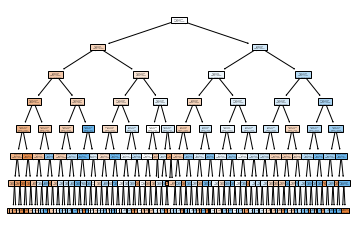

In [37]:
fig1 = tree_clf.fit(X_train_train, y_train_train)
tree.plot_tree(fig, filled = True)
plt.show()

In [40]:
tree_clf_plot = DecisionTreeClassifier(max_depth = 3)
fig2 = tree_clf_plot.fit(X_train_train, y_train_train)

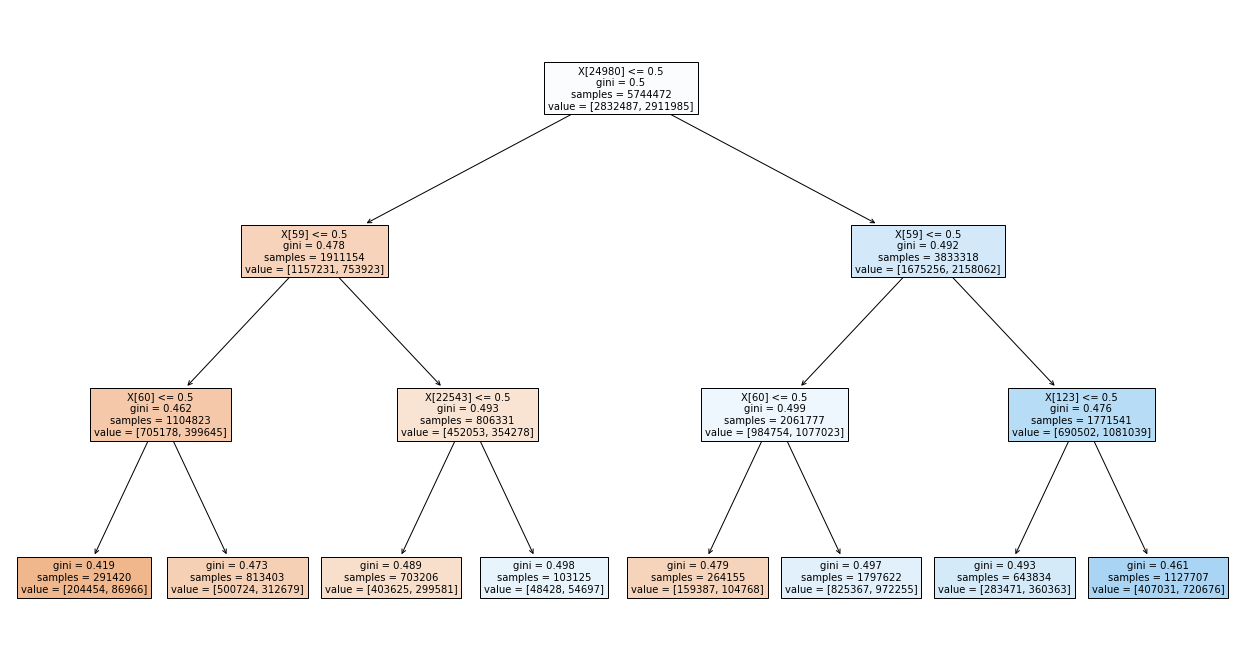

In [49]:
plt.figure(figsize=(22,12))
tree.plot_tree(fig2, filled = True, fontsize=10)
plt.show()